In [1]:
## This notebook describes how to use some basic functionalities of s4cmb such as
## * simulate an input sky
## * simulate an instrument 
## * simulate a scanning strategy
## * simulate TOD from the 3 previous guys
## * project back your TOD to sky map.

In [2]:
## Include the path to the package
import sys
import os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../s4cmb')))

## Import modules and routines
from input_sky import HealpixFitsMap
from input_sky import create_sky_map
from input_sky import write_healpix_cmbmap

from instrument import Hardware

from scanning_strategy import ScanningStrategy

from tod import TimeOrderedDataPairDiff
from tod import partial2full

## Other packages needed
import healpy as hp
import pylab as pl
import numpy as np

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

In [3]:
## Create a fake input if necessary
if not os.path.isfile('mymaps.fits'):
    sky = create_sky_map('../s4cmb/data/test_data_set_lensedCls.dat', nside=512)
    write_healpix_cmbmap(output_filename='mymaps.fits', data=sky, nside=512)

In [4]:
###########################################################################################
## START OF THE SIMULATION
## Flow is the following: 
##   sky -> instrument -> scanning strategy -> MAP2TOD -> (systematics) -> TOD2MAP
###########################################################################################

In [5]:
## Initialise our input maps
sky_in = HealpixFitsMap('mymaps.fits', do_pol=True, verbose=False, no_ileak=False, no_quleak=False)

In [6]:
## Initialise our instrument
## Generate a focal plane with 4 Crate boards, each with 1 MUX board, 
## each with 1 Squid, each with 16 pairs of bolometers.
## The focal plane is 60 cm wide (square),
## and each detector beam is Gaussian with FWHM of 3.5 arcmin.
## We choose a pointing model with 5 parameters.
## Finally, we mount a continously rotating HWP @ 2Hz on the instrument.
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., FWHM=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_HWP='CRHWP', freq_HWP=2., angle_HWP=0., debug=False)

In [7]:
## Initialize our scanning strategy
## Our scanning strategy will consist in scanning the Southern sky from Chile.
## We will perform 1 deep scan (CES) of roughly 4h.
## We will start the observation January, 1st 2013.
## We will set the sampling frequency of the detector to be 8 Hz, and we will 
## scan the sky at a speed of 0.4 deg/s.
scan = ScanningStrategy(nCES=1, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../s4cmb/data/ut1utc.ephem', language='fortran')
scan.run()

In [8]:
## Let's now generate our TOD from our input sky, instrument, and scanning strategy
## Firts, we will sue the difference of pairs of detectors to reconstruct the polarisation (no demodulation).
## Once we will have the timestreams, we will reconstruct our maps on a sky patch of width 20 deg at  
## a resolution nside = 512.
tod = TimeOrderedDataPairDiff(inst, scan, sky_in, nside_out=512, width=20.)

## MAP2TOD: scan the input sky to generate timestream channel-by-channel.
## this is currently the bottleneck in computation. Need to speed-up this routine!
## Hopefully everything is linear ;-)
d = []
for det in tqdm(range(inst.focal_plane.nbolometer)):
    d.append(tod.map2tod(det))

100%|██████████| 128/128 [00:07<00:00, 17.60it/s]


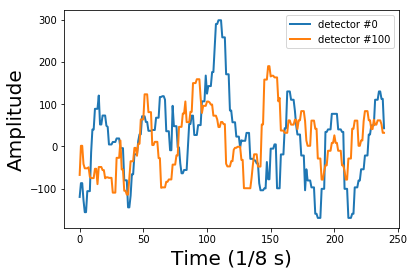

In [9]:
## Here would be the moment to insert systematics! But I leave that for another notebook :-)
## Let's have a look at some distant detectors timestreams for 30 seconds of scan
## (remember we have a sample rate of 8 Hz):
pl.plot(d[0][0:240], label='detector #0', lw=2)
pl.plot(d[100][0:240], label='detector #100', lw=2)
pl.xlabel('Time (1/8 s)', fontsize=20)
pl.ylabel('Amplitude', fontsize=20)
pl.legend()
pl.show()

In [10]:
## Now let's project back our TOD to the sky (TOD2MAP)
tod.tod2map(np.array(d))

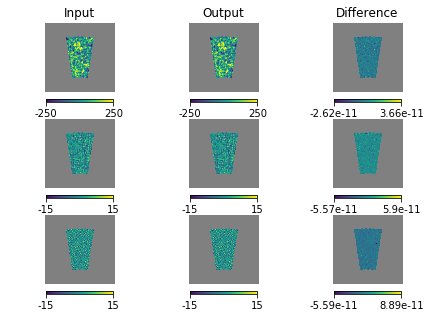

In [13]:
## In the absence of systematics, these operations should not change the 
## signal. Let's check that we did not harm the signal.

## Temperature
sky_out = partial2full(tod.get_I(), tod.obspix, tod.nside_out, fill_with=0.0)
mask = sky_out == 0.0
sky_in.I[mask] = np.nan
sky_out[mask] = np.nan
hp.gnomview(sky_in.I, rot=[0, -57.5], xsize=300, reso=6.9, sub=331, title='Input', notext=True, min=-250, max=250)
hp.gnomview(sky_out, rot=[0, -57.5], xsize=300, reso=6.9, sub=332, title='Output', notext=True, min=-250, max=250)
hp.gnomview(sky_in.I - sky_out, rot=[0, -57.5], xsize=300, reso=6.9, sub=333, title='Difference', notext=True)

## Stokes Q
sky_out = partial2full(tod.get_QU()[0], tod.obspix, tod.nside_out, fill_with=0.0)
mask = sky_out == 0
sky_in.Q[mask] = np.nan
sky_out[mask] = np.nan

hp.gnomview(sky_in.Q, rot=[0, -57.5], xsize=300, reso=6.9, sub=334, notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=300, reso=6.9, sub=335,  notext=True, min=-15, max=15, title='')
hp.gnomview(sky_in.Q - sky_out, rot=[0, -57.5], xsize=300, reso=6.9, sub=336, notext=True, title='')

## Stokes U
sky_out = partial2full(tod.get_QU()[1], tod.obspix, tod.nside_out, fill_with=0.0)
mask = sky_out == 0
sky_in.U[mask] = np.nan
sky_out[mask] = np.nan
hp.gnomview(sky_in.U, rot=[0, -57.5], xsize=300, reso=6.9, sub=337, notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=300, reso=6.9, sub=338, notext=True, min=-15, max=15, title='')
hp.gnomview(sky_in.U - sky_out, rot=[0, -57.5], xsize=300, reso=6.9, sub=339, notext=True, title='')
pl.show()

In [14]:
## If you obtain O(1e-10) for the last column, that works!
## Now it is time to put our hands in the world of systematics :-)